### `DATA 228: Assignment No 5 :` Eshita Gupta/016978741
### Ques 2: Download the adult income data using the following link:https://archive.ics.uci.edu/dataset/2/adult. Perform the machine learning task using PySpark. Providethe PySpark code and results for the following questions.

### 2(a) Load the “adult.data” using PySpark. Rename the columns according to the“Variable Name” from the website. Show the schema and the first 10 rows of the dataset.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql import functions as F


In [3]:
spark = SparkSession.builder \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .appName('Adult_income_data') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/08 21:15:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
# Define the schema
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", IntegerType(), True),
    StructField("education", StringType(), True),
    StructField("education_num", IntegerType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital-gain", IntegerType(), True),
    StructField("capital-loss", IntegerType(), True),
    StructField("hours_per_week", IntegerType(), True),
    StructField("native_country", StringType(), True),
    StructField("income", StringType(), True)
])

In [6]:
# Load the data with the schema
adult_df = spark.read.csv("adult.data", schema=schema, sep=", ")
adult_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [7]:
# check the shape of the dataset
adult_df.count(), len(adult_df.columns)

(32561, 15)

In [8]:
# Show the first 10 rows of the dataframe
adult_df.show(10)

+---+----------------+------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|education|education_num|      marital_status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours_per_week|native_country|income|
+---+----------------+------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 39|       State-gov| 77516|Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States| <=50K|
| 38|         Private|215646|  HS-grad|            9|            Divorced|Handlers-cl

### 2(b) Calculate the percentage of missing values for each column in the dataset.

In [9]:
# find the number of missing values in each column
print("Number of missing values in each column")
adult_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in adult_df.columns]).show()

Number of missing values in each column
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital-gain|capital-loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



Here, dataframe shows no missing values, however, we want to check for the unique values to see if all the values for the particular column is right.

In [10]:
#find the unique values in categorical columns
print("Unique values in categorical columns")
for col in ["workclass", "education", "marital_status", "occupation", "relationship",
            "race","sex","native_country"]:
    print(f"Unique values in {col} column")
    
    adult_df.select(col).distinct().show()

Unique values in categorical columns
Unique values in workclass column
+----------------+
|       workclass|
+----------------+
|Self-emp-not-inc|
|       Local-gov|
|       State-gov|
|         Private|
|     Without-pay|
|     Federal-gov|
|    Never-worked|
|               ?|
|    Self-emp-inc|
+----------------+

Unique values in education column
+------------+
|   education|
+------------+
|     Masters|
|        10th|
|     5th-6th|
|  Assoc-acdm|
|   Assoc-voc|
|     7th-8th|
|         9th|
|     HS-grad|
|   Bachelors|
|        11th|
|     1st-4th|
|   Preschool|
|        12th|
|   Doctorate|
|Some-college|
| Prof-school|
+------------+

Unique values in marital_status column
+--------------------+
|      marital_status|
+--------------------+
|           Separated|
|       Never-married|
|Married-spouse-ab...|
|            Divorced|
|             Widowed|
|   Married-AF-spouse|
|  Married-civ-spouse|
+--------------------+

Unique values in occupation column
+-----------------

From above unique values in categorical columns, we found out that 3 columns has values as "?". So, these are the values which needs to handled

In [11]:
# find percentage of values in all columns which has "?"

print("Percentage of values in all columns which has '?'")
adult_df.select([F.round((F.sum(F.when(F.col(c) == "?", 1).otherwise(0)) / F.count(c)) * 100, 2).alias(c) 
                 for c in adult_df.columns]).show()


Percentage of values in all columns which has '?'
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital-gain|capital-loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|0.0|     5.64|   0.0|      0.0|          0.0|           0.0|      5.66|         0.0| 0.0|0.0|         0.0|         0.0|           0.0|          1.79|   0.0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [12]:
# drop the rows with "?" values
adult_df = adult_df.filter(adult_df["workclass"] != "?")
adult_df = adult_df.filter(adult_df["occupation"] != "?")
adult_df = adult_df.filter(adult_df["native_country"] != "?")

In [13]:
# check the shape of the dataset
adult_df.count(), len(adult_df.columns)

(30162, 15)

In [14]:
# find the number of missing values in each column
print("Number of missing values in each column")
adult_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in adult_df.columns]).show()

# find the unique values in categorical columns
print("Unique values in categorical columns")
for col in ["workclass", "education", "marital_status", "occupation", "relationship",
            "race","sex","native_country"]:
    print(f"Unique values in {col} column")
    
    adult_df.select(col).distinct().show()


Number of missing values in each column
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital-gain|capital-loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+

Unique values in categorical columns
Unique values in workclass column
+----------------+
|       workclass|
+----------------+
|Self-emp-not-inc|
|       Local-gov|
|  

Now, our dataset is clean with no irrelevant value in categorical columns and no missing values

### 2(c) Convert the “income” variable to a new column named “label”, label =0 if“income”<=50K, label=1 if “income”>50K

In [15]:
# create a new column called label

adult_df = adult_df.withColumn("label",
                               F.when(F.col("income") == "<=50K", 0)
                               .otherwise(1))
adult_df.show()


+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+-----+
|age|       workclass|fnlwgt|   education|education_num|      marital_status|       occupation| relationship|              race|   sex|capital-gain|capital-loss|hours_per_week|native_country|income|label|
+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+-----+
| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States| <=50K|    0|
| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|             White|  Male|           0|           0|            13| Uni

### 2(d) Create the feature vector by combining all input features into a single vector.

In [16]:
from pyspark.ml.feature import VectorAssembler, StringIndexer        

# List of categorical features
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']

# Create StringIndexer objects for each categorical feature
indexers = []
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep")
    indexer_model = indexer.fit(adult_df)
    indexers.append(indexer_model)

# Apply the indexers
encoded_df = adult_df
for indexer in indexers:
    encoded_df = indexer.transform(encoded_df)
    
# Drop the columns with the _index suffix
cols_to_drop = [col + "_index" for col in categorical_cols]
encoded_df = encoded_df.drop(*cols_to_drop)

# List of input features (including encoded categorical features)
input_cols = ['age', 'fnlwgt', 'education_num', 'capital-gain', 'capital-loss', 'hours_per_week']
input_cols.extend([col + "_indexed" for col in categorical_cols])

# Create a VectorAssembler object
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transform the DataFrame to create the feature vector
assembled_df = assembler.transform(encoded_df)

# Show the schema of the transformed DataFrame
assembled_df.printSchema()

# Show the first 10 rows of the transformed DataFrame
assembled_df.show(10)


root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- workclass_indexed: double (nullable = false)
 |-- education_indexed: double (nullable = false)
 |-- marital_status_indexed: double (nullable = false)
 |-- occupation_indexed: double (nullable = false)
 |-- relationship_indexed: double (nullable = false)
 |-- race_indexed: double (nullable = false)
 |-- sex_indexed: double 

24/05/08 21:20:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+----------------+------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+-----+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+--------------------+
|age|       workclass|fnlwgt|education|education_num|      marital_status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours_per_week|native_country|income|label|workclass_indexed|education_indexed|marital_status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native_country_indexed|            features|
+---+----------------+------+---------+-------------+--------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+-----+-----------------+-----------------+----------------------+------------------+--------------------

In [17]:
# print only the feature column
assembled_df.select("features").show(10, truncate=False)


+--------------------------------------------------------------------+
|features                                                            |
+--------------------------------------------------------------------+
|[39.0,77516.0,13.0,2174.0,0.0,40.0,3.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0] |
|(14,[0,1,2,5,6,7,9],[50.0,83311.0,13.0,13.0,1.0,2.0,2.0])           |
|(14,[0,1,2,5,8,9,10],[38.0,215646.0,9.0,40.0,2.0,8.0,1.0])          |
|(14,[0,1,2,5,7,9,11],[53.0,234721.0,7.0,40.0,5.0,8.0,1.0])          |
|[28.0,338409.0,13.0,0.0,0.0,40.0,0.0,2.0,0.0,0.0,4.0,1.0,1.0,8.0]   |
|(14,[0,1,2,5,7,9,10,12],[37.0,284582.0,14.0,40.0,3.0,2.0,4.0,1.0])  |
|[49.0,160187.0,5.0,0.0,0.0,16.0,0.0,10.0,5.0,5.0,1.0,1.0,1.0,10.0]  |
|(14,[0,1,2,5,6,9],[52.0,209642.0,9.0,45.0,1.0,2.0])                 |
|[31.0,45781.0,14.0,14084.0,0.0,50.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0]|
|(14,[0,1,2,3,5,7,9],[42.0,159449.0,13.0,5178.0,40.0,2.0,2.0])       |
+--------------------------------------------------------------------+
only s

24/05/08 22:20:42 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 125735 ms exceeds timeout 120000 ms
24/05/08 22:20:42 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/08 22:20:43 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [18]:
# find the unique values in the indexed categorical columns
print("Unique values in indexed categorical columns")
for col in [col + "_indexed" for col in categorical_cols]:
    print(f"Unique values in {col} column")
    
    assembled_df.select(col).distinct().show()

Unique values in indexed categorical columns
Unique values in workclass_indexed column
+-----------------+
|workclass_indexed|
+-----------------+
|              0.0|
|              1.0|
|              4.0|
|              3.0|
|              2.0|
|              6.0|
|              5.0|
+-----------------+

Unique values in education_indexed column
+-----------------+
|education_indexed|
+-----------------+
|              8.0|
|              0.0|
|              7.0|
|              1.0|
|              4.0|
|             11.0|
|             14.0|
|              3.0|
|              2.0|
|             10.0|
|             13.0|
|              6.0|
|              5.0|
|             15.0|
|              9.0|
|             12.0|
+-----------------+

Unique values in marital_status_indexed column
+----------------------+
|marital_status_indexed|
+----------------------+
|                   0.0|
|                   1.0|
|                   4.0|
|                   3.0|
|                   2.0|
| 

### 2(e) Split the dataset into training and test sets using a 8:2 ratio and set the random seedto 123.

In [19]:
# Split the data into training and testing sets
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=123)

print("Number of training set rows: ", train_df.count())
print("Number of testing set rows: ", test_df.count())

Number of training set rows:  24055
Number of testing set rows:  6107


### 2(f) Use the Logistic Regression model for binary classification for the adult incomedataset and print the AUC (Area Under ROC) of the test data.


In [26]:
# Train a logistic regression model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Create a LogisticRegression object
lr = LogisticRegression(featuresCol="features", labelCol="label")

# train the model
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"AUC on test data: {auc}")

AUC on test data: 0.8812053270097233


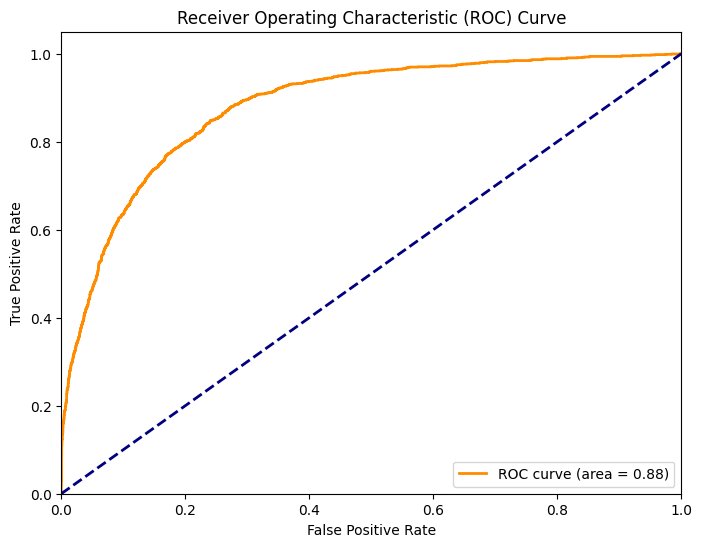

In [27]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from sklearn import metrics

# Collect the predictions and labels as NumPy arrays
predictions_collect = predictions.select("rawPrediction", "label").toPandas()
labels = predictions_collect["label"].values
scores = [row.toArray()[1] for row in predictions_collect["rawPrediction"]]

# Calculate the false positive rates and true positive rates
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

# Calculate the AUC
roc_auc = metrics.auc(fpr, tpr)

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Thank You!!